In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.nn import init
import time

In [3]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
# Network Architecture
num_inputs = 28*28
num_hidden = 2000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [15]:
def generate_spike(x):
    data_input = x.view(128,-1)
    spk_input = []
    for batch in range(128):
        spk_input_batch = spikegen.rate(data_input[batch], num_steps = 25)
        spk_input.append(spk_input_batch)
    return torch.stack(spk_input, dim = 1)

In [31]:
num_epochs = 1
loss_hist = []

start_time = time.time()

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(generate_spike(data))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # another loss
        idx = spk_rec.sum(dim=0)
        loss_val = loss(idx, targets)
        

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        iter_counter += 1
        if iter_counter == 200:
            break

end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time
print(f"操作所花费的时间为: {elapiens_time} 秒")

In [33]:
num_epochs = 1
test_result = []
test_tgt = []
test_loss_hist = []
# test loop
for epoch in range(num_epochs):
    iter_counter = 0
    test_batch = iter(test_loader)
    # Test set
    with torch.no_grad():
        net.eval()
        for test_data, test_targets in test_batch:
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            # Test set forward pass
            test_spk, test_mem = net(generate_spike(test_data))
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            
            test_tgt.append(test_targets)
            _, idx = test_spk.sum(dim=0).max(1)
            test_result.append(idx)

            iter_counter += 1
            if iter_counter == 50:
                break

In [35]:
sum(torch.stack(test_result, dim=0).reshape(-1) == torch.stack(test_tgt, dim=0).reshape(-1))/6400

tensor(0.9453)

In [37]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

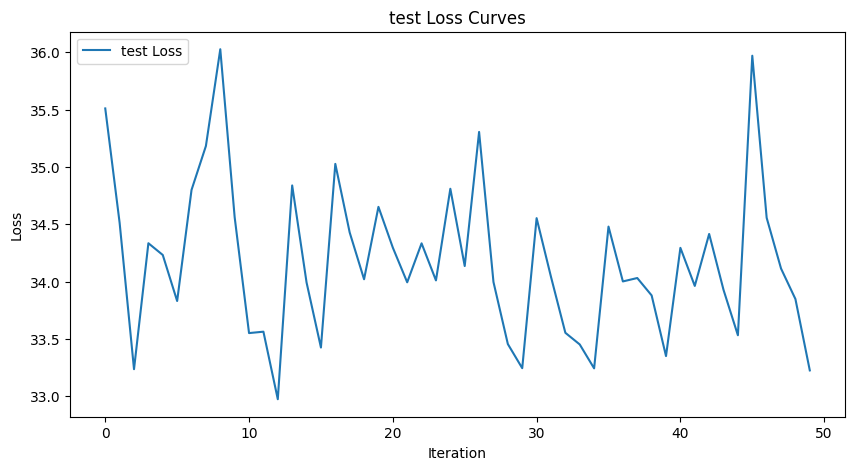

In [39]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(test_loss_hist)
plt.title("test Loss Curves")
plt.legend(["test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [43]:
# total = 0
# correct = 0

# # drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# with torch.no_grad():
#   net.eval()
#   for data, targets in test_loader:
#     data = data.to(device)
#     targets = targets.to(device)

#     # forward pass
#     test_spk, _ = net(generate_spike(data))

#     # calculate total accuracy
#     _, predicted = test_spk.sum(dim=0).max(1)
#     total += targets.size(0)
#     correct += (predicted == targets).sum().item()

# my snn-training method

In [54]:
# Define Network
class my_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [56]:
#重新创建网络
net1 = my_Net().to(device)
train_result = []
train_tgt = []
for epoch in range(num_epochs):
    iter_counter = 0
    test_batch = iter(train_loader)
    # Test set
    with torch.no_grad():
        net1.eval()
        for train_data, train_targets in test_batch:
            train_data = train_data.to(device)
            train_targets = train_targets.to(device)
            # Test set forward pass
            train_spk, train_mem = net1(generate_spike(train_data))
            
            train_tgt.append(train_targets)
            train_result.append(train_spk)

            iter_counter += 1
            if iter_counter == 200:
                break

In [132]:
train_net = torch.nn.Linear(2000,10)

In [134]:
optimizer1 = torch.optim.Adam(train_net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [136]:
my_train_loss_hist = []
for batch in range(100):
    train_net_out = train_net(torch.stack(train_result, dim=0).sum(dim = 1)[batch])
    train_loss = torch.zeros((1), dtype=dtype, device=device)
    train_loss = loss(train_net_out, torch.stack(train_tgt, dim=0)[batch])
    # Gradient calculation + weight update
    optimizer1.zero_grad()
    train_loss.backward()
    optimizer1.step()
    my_train_loss_hist.append(train_loss.item())

In [138]:
my_train_loss_hist

[2.5390028953552246,
 2.356435537338257,
 2.280365228652954,
 2.2117857933044434,
 2.15615177154541,
 2.1277883052825928,
 1.9993171691894531,
 2.0628139972686768,
 2.0179691314697266,
 1.901410698890686,
 1.8581123352050781,
 1.8219667673110962,
 1.732922911643982,
 1.7196301221847534,
 1.643534779548645,
 1.630564570426941,
 1.6868460178375244,
 1.5518378019332886,
 1.5257294178009033,
 1.486737847328186,
 1.4523944854736328,
 1.378610372543335,
 1.4808217287063599,
 1.3803017139434814,
 1.3342134952545166,
 1.2676881551742554,
 1.2390706539154053,
 1.3122961521148682,
 1.187419056892395,
 1.2141008377075195,
 1.2520403861999512,
 1.1602550745010376,
 1.177526831626892,
 1.2210049629211426,
 1.11265230178833,
 1.097233533859253,
 1.2059036493301392,
 1.0277676582336426,
 1.062938928604126,
 1.0661735534667969,
 0.9630774855613708,
 0.9129797220230103,
 0.9547197222709656,
 0.9472829699516296,
 0.8450548648834229,
 0.9513688087463379,
 0.9532245397567749,
 0.9207562208175659,
 0.90824

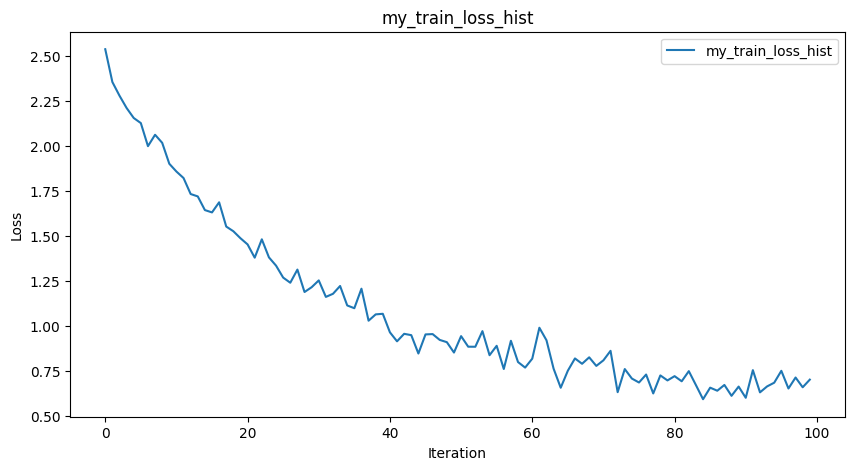

In [140]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(my_train_loss_hist)
plt.title("my_train_loss_hist")
plt.legend(["my_train_loss_hist"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [142]:
# test my net
my_test_result = []
my_test_tgt = []
for epoch in range(num_epochs):
    iter_counter = 0
    test_batch = iter(test_loader)
    # Test set
    with torch.no_grad():
        net1.eval()
        for my_test_data, my_test_targets in test_batch:
            my_test_data = my_test_data.to(device)
            my_test_targets = my_test_targets.to(device)
            # Test set forward pass
            my_test_spk, my_test_mem = net1(generate_spike(my_test_data))
            
            my_test_tgt.append(train_targets)
            my_test_result.append(train_spk)

            iter_counter += 1
            if iter_counter == 50:
                break

In [200]:
torch.stack(my_test_result, dim=0).sum(dim = 1)[0][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [148]:
torch.stack(my_test_tgt, dim=0).shape

torch.Size([50, 128])

In [188]:
max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)[1]).max(dim = 1)

In [190]:
max_index.shape

torch.Size([128])

In [192]:
torch.sum(torch.stack(my_test_tgt, dim=0)[1]==max_index)

tensor(113)

In [182]:
my_test_sum = []
for batch in range(50):
    
    max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)[batch]).max(dim = 1)
    sum = torch.sum(torch.stack(my_test_tgt, dim=0)[batch]==max_index)
    my_test_sum.append(sum)

In [184]:
my_test_sum

[tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113),
 tensor(113)]

In [202]:
113/128

0.8828125